In [ ]:
!pip install ultralytics opencv-python-headless matplotlib

In [ ]:
# Step 2: Import libraries
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab import files

In [ ]:
# Step 3: Load YOLOv8 pre-trained model
model = YOLO('yolov8m.pt')  # Use 'yolov8m.pt' for better accuracy

In [ ]:
# Step 4: Upload or load a sample video
uploaded = files.upload()  # Prompts you to upload your video file

Saving test2.mp4 to test2 (1).mp4


In [ ]:
# Step 5: Initialize variables
player_tracks = defaultdict(list)  # Store player positions for heatmap
unique_ids = {}
next_id = 1
last_frame = None  # To store the last processed frame for heatmap

In [ ]:
# Step 6: Define the video processing function (and probably colour classification)
def process_video(video_path):
    global next_id, last_frame
    cap = cv2.VideoCapture(video_path)
    out = None  # Initialize VideoWriter
    inactive_threshold = 30  # Number of frames to consider a player inactive

    # Dictionary to track the frame counts since last detection
    inactive_counts = {id: 0 for id in unique_ids.values()}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        last_frame = frame.copy()  # Store the current frame for later use
        results = model.predict(frame)  # Run YOLOv8 detection on each frame
        current_ids = []  # To keep track of current frame IDs

        detected_boxes = []

        for detection in results[0].boxes:  # Might need to access boxes differently in YOLOv8
            x1, y1, x2, y2 = map(int, detection.xyxy[0])  # Adjust access here if necessary
            confidence = detection.conf[0]

            if confidence > 0.5:  # Confidence threshold
                detected_boxes.append((x1, y1, x2, y2))

        # Reset inactive counts for current IDs
        for id in inactive_counts:
            inactive_counts[id] += 1  # Increment inactive count for all IDs

        # Match detected boxes with existing IDs
        for box in detected_boxes:
            x1, y1, x2, y2 = box
            center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
            assigned_id = None

            # Check if the center is close to any existing player positions
            for existing_id, positions in player_tracks.items():
                if positions:  # Check if there are recorded positions
                    last_position = positions[-1]
                    if np.linalg.norm(np.array(center) - np.array(last_position)) < 50:  # Distance threshold
                        assigned_id = existing_id
                        break

            # Assign new ID if no existing ID is found
            if assigned_id is None:
                assigned_id = next_id
                next_id += 1

            current_ids.append(assigned_id)
            player_tracks[assigned_id].append(center)

            # Reset inactive count for this ID
            inactive_counts[assigned_id] = 0

            # Draw bounding box and label
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'Player {assigned_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Check for inactive players
        for player_id in list(inactive_counts.keys()):
            if inactive_counts[player_id] > inactive_threshold:
                # Consider the player as no longer active
                del player_tracks[player_id]
                del inactive_counts[player_id]

        # Initialize VideoWriter on first frame
        if out is None:
            out = cv2.VideoWriter('tracked_players.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (frame.shape[1], frame.shape[0]))

        out.write(frame)  # Write the processed frame to the video

    cap.release()
    out.release()

In [ ]:
# Step 7: Run the function on your uploaded video
video_path = next(iter(uploaded))  # Get the uploaded file's path
process_video(video_path)


0: 384x640 20 persons, 2299.7ms
Speed: 8.1ms preprocess, 2299.7ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 2002.3ms
Speed: 7.0ms preprocess, 2002.3ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 1925.1ms
Speed: 4.7ms preprocess, 1925.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 1993.8ms
Speed: 4.8ms preprocess, 1993.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 1795.1ms
Speed: 4.6ms preprocess, 1795.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 2636.4ms
Speed: 4.2ms preprocess, 2636.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 3011.5ms
Speed: 4.3ms preprocess, 3011.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 2385.2ms
Speed: 20.0ms preprocess, 2385.2ms inferenc

In [ ]:
# Step 8: Generate Heatmap for a selected player
def generate_heatmap(player_id):
    global last_frame
    if player_id not in player_tracks:
        raise ValueError(f"Player ID {player_id} not found in tracking data.")

    heatmap = np.zeros((last_frame.shape[0], last_frame.shape[1]), dtype=np.float32)

    # Add positions to the heatmap
    for pos in player_tracks[player_id]:
        heatmap[pos[1], pos[0]] += 1  # Increment the heatmap at the player's positions

    # Normalize the heatmap
    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap = np.uint8(heatmap)

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay the heatmap on the last processed frame for visualization
    overlay = cv2.addWeighted(last_frame, 0.5, heatmap_colored, 0.5, 0)

    return overlay


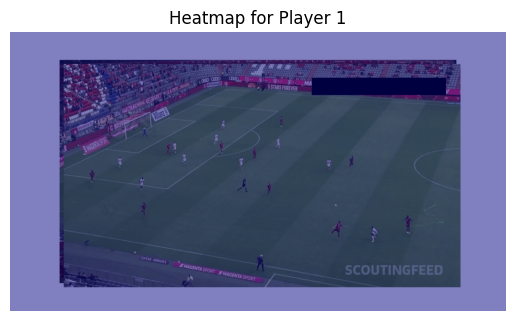

In [ ]:
# Example usage for generating a heatmap for a selected player
if player_tracks:
    player_id_to_visualize = 1  # Change this to visualize a different player
    if player_id_to_visualize in player_tracks:
        heatmap_frame = generate_heatmap(player_id_to_visualize)
        plt.imshow(cv2.cvtColor(heatmap_frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Heatmap for Player {player_id_to_visualize}')
        plt.show()
    else:
        print(f"Player ID {player_id_to_visualize} not found in tracking data.")


In [ ]:
from google.colab import files
files.download('test.mp4')  # Downloads the processed video

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>